In [38]:
from keras.preprocessing.image import img_to_array, load_img
from PIL import Image
import random
import numpy as np
import glob
import os

def loadImage(img_path, outputs = 0, number = 0):
    pix = np.asarray(Image.open(img_path).convert('L'))
    pix = ((pix * (1 / 2550) - 0.05)).reshape(784)
    if outputs != 0:
        for i in outputs:
            if i == number:
                pix = np.append(pix, 1)
            else:
                pix = np.append(pix, 0)
    return pix

def load_training_dataset(outputs, data_nb = 0):
    dataset = []
    path = 'Training data/'
    
    filenames = []
    for o in outputs:
        for filename in glob.glob(path + str(o) + '/*.png'): 
            base = os.path.basename(filename)
            filenames.append([str(o) + '/' + base, o])
    
    random.shuffle(filenames)
    if data_nb != 0:
        filenames = filenames[:data_nb]
        
    for file in filenames:
        dataset.append(loadImage(path + file[0], outputs, file[1]))
        
    print('end loading dataset')
    return dataset

def load_dataset(path):
    dataset = []
    filenames = []
    for filename in glob.glob(path + '/*.png'): 
        dataset.append(loadImage(filename))
        base = os.path.splitext(os.path.basename(filename))[0]
        filenames.append(base)
     
    return len(dataset), filenames


In [39]:
def predict(path, outputs):
    predict_o = []
    filenames = []
    correct = 0
    for number in outputs:
        for filename in glob.glob(path + str(number) + '/*.png'):
            base = os.path.splitext(os.path.basename(filename))[0]
            data = loadImage(filename)
            filenames.append(base)
            
            output = forward_prop(network, data)

            val = [i for i in np.where(outputs == np.amax(outputs))]
            ans = np.around(outputs[val[0][0]]).astype(int)
            if ans == number:
                correct += 1
            predict_o.append(ans)
            
    final = list()

    for i in range(len(filenames)):
        final.append({ filenames[i] : predict_o[i]})


    with open('outputs.txt', 'w') as f:
        for item in final:
            f.write("%s\n" % str(item).replace('{', '').replace('}', '').replace("'", '').replace(':', ''))
            
    print('correct : ' + str(correct) + ' (' + str(correct / len(filenames)) + ' %)')
    print('wrong : ' + str(len(filenames) - correct) + ' (' + str((len(filenames) - correct) / len(filenames)) + ' %)')
    return final


In [40]:

def retrain(data_type, data_nb, nb_iter = 0, outputs = []):

    nb_outputs = 0
    nb_inputs = 0
    
    #for images
    if data_type == 'img':
        nb_inputs = 28 * 28
        nb_outputs = len(outputs)
        x = np.array(load_training_dataset(outputs, data_nb), dtype=np.dtype(Decimal))
        x = [[ Decimal(i) for i in j] for j in x]
    elif data_type == 'xor':
        nb_outputs = 3
        nb_inputs = 2
        x = [[1, 0, 1, 1, 1], [1, 1, 0, 1, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 1]]
    else:
        return 'Wrong datatype (should be img or xor)'


    return train_network(network, x, 1, nb_outputs, nb_iter)

In [48]:
import numpy as np
import math
import matplotlib.pyplot as plt

def sigmoid(x):
    #print(1 / (1 + np.exp(-x)))
    return 1 / (1 + np.exp(-x))

 
def error_function(expected, outputs):
    return (1/len(outputs)) * sum(np.square(expected - outputs))

def forward_prop(network, inputs):
    vect_sigmoid = np.vectorize(sigmoid)
    for i in range(len(network)):
        layer = network[i]
        new_inputs = []
        #print('-----------------')
        #print(np.dot(layer[1]['w'], inputs))
        #print('------------------')
        layer[0]['a'] = vect_sigmoid(np.dot(layer[1]['w'], inputs))

        new_inputs.append(layer[0]['a'])
        inputs = new_inputs[0]
    return np.matrix(inputs)

# Update network weights with error
def update_weights(network, data, l_rate):
    delta = []
    for i in range(len(network)):
        layer = network[i]
        
        for neuron in range(len(layer[1]['w'])):
            for b_neuron in range(len(layer[1]['w'][neuron])):
                if i != 0:
                    delta = l_rate * layer[3]['e'][neuron] * network[i - 1][0]['a'][b_neuron]
                else:
                    delta = l_rate * layer[3]['e'][neuron] * data[b_neuron]
                layer[1]['w'][neuron][b_neuron] = layer[1]['w'][neuron][b_neuron] + delta
        
def backward_prop_error(network, expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = []
        
        # case where it is not the output layer
        if i != len(network)-1:
            o_errors = network[i + 1][3]['e']
            o_weights = network[i + 1][1]['w']
            
            errors = np.dot(
                np.dot(o_weights.T, o_errors),
                np.dot((layer[0]['a'].T), 1 - layer[0]['a']))
            
            layer[3]['e'] = errors
        else:
            errors = np.dot(expected.T - layer[0]['a'], np.dot((layer[0]['a']).T, (1 - layer[0]['a'])))
            layer[3]['e']  = errors
            
def update_line(hl, new_data, iter):
    hl.set_xdata(np.append(hl.get_xdata(), iter))
    hl.set_ydata(np.append(hl.get_ydata(), new_data))
    plt.draw()
    

def train_network(network, train, l_rate, nb_outputs, nb_iter):
    err_plot, = plt.plot([], [])
    plt.ylabel('error')
    axes = plt.gca()
    iter = 0
    min_err = 2
    for epoch in range(nb_iter):
        error = 0
        iter = 0
        for data in train:
            new_data = data
            iter += 1
            print(iter)
            expected = np.delete(new_data, np.s_[0:(data.shape)[1] - nb_outputs], axis=1)
            new_data = (np.delete(new_data, np.s_[(data.shape)[1] - nb_outputs:(data.shape)[1]], axis=1)).T
            outputs = forward_prop(network, new_data)
            
            error += error_function(expected.T, outputs)
            backward_prop_error(network, expected)
            
            l_rate = 1
            update_weights(network, new_data, l_rate)
        
        final_err = error / len(train)
        print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, final_err))
        if epoch == 0:
            axes.set_xlim([0, nb_iter])
            axes.set_ylim([0, float(final_err) + 0.1])
            
        update_line(err_plot, final_err, epoch)
        
        if error < min_err:
            min_err = final_err
        if error < 0.0001:
            print('error : ' + str(final_err))
            return network
    print('error     : ' + str(final_err))
    print('min error : ' + str(min_err))
    return network
   

def initialize_network(nb_inputs, nb_hidden, nb_hidden_layers, nb_outputs):
    network = list()
    w = []
    
    # additionnal hidden layers
    for i in range(nb_hidden_layers):
        neurons = [{ 'neurons': nb_hidden[i]}]
        if i == 0:
            w.append(np.random.uniform(low=-0.5, high=0.5, size=(nb_hidden[i], nb_inputs)))
            #w.append(np.matrix(np.random.rand(nb_hidden[i], nb_inputs)) / 1000) 
        else:
            w.append(np.random.uniform(low=-0.9, high=0.9, size=(nb_hidden[i], nb_hidden[i - 1])))
            #w.append(np.matrix(np.random.rand(nb_hidden[i], nb_hidden[i - 1])) / 100)
        network.append(neurons)
    
    # output layer
    neurons = [{ 'neurons': nb_outputs}]
    w.append(np.random.uniform(low=-0.5, high=0.5, size=(nb_outputs, nb_hidden[nb_hidden_layers - 1])))
    #w.append(np.matrix(np.random.rand(nb_outputs, nb_hidden[nb_hidden_layers - 1])))
    network.append(neurons)
    
    for layer in network:
              
        wTmp = {'w': w[0]}
        layer.append(wTmp)
        w.pop(0)
        
        aTmp = { 'a': np.matrix(np.random.rand(layer[0]['neurons']))}
        layer.append(aTmp)
        
        eTmp = { 'e': np.matrix(np.random.rand(layer[0]['neurons']))}
        layer.append(eTmp)
        
    print('end initializing network')
    return network
  
    
# data_type => either 'img' or 'xor'
# data_nb => number of data rows (entries)
# nb_iter => number of iterations ot get to result?
# outputs => list of outputs (from 0 to 9 for img), not necessary for XOR
# nb_hidden layer => number of hidden layers, 1 by default
# nb_hidden => number of hidden neurons on each hidden layer ( 2 by default )

# load input : load_testing_dataset(data_nb)
def test(network, dataset, data_nb, categories = [], filenames = []):
    outputs = list()
    if data_nb == 1:
        outputs = forward_prop(network, dataset)
    else:
        for data in dataset:
            outputs.append(forward_prop(network, data))
   
    if categories != []:
        for m in range(len(outputs)):
            val = [i for i in np.where(outputs[m] == np.amax(outputs[m]))]
            outputs[m] = categories[val[0][0]]
    
    results = outputs
    
    if filenames == []:
        return results
    else :
        results = np.around(outputs).astype(int)
        final = list()

        for i in range(len(results)):
            final.append({ filenames[i] : results[i]})
            

        with open('outputs.txt', 'w') as f:
            for item in final:
                f.write("%s\n" % str(item).replace('{', '').replace('}', '').replace("'", '').replace(':', ''))
        return final
    

def train(data_type, data_nb, nb_iter = 0, outputs = [], nb_hidden = [16], nb_hidden_layer = 1, dataset = []):

    nb_outputs = 0
    nb_inputs = 0
    #for imagesTra
    if data_type == 'img':
        nb_inputs = 28 * 28
        nb_outputs = len(outputs)
        if dataset == []:
            x = np.matrix(load_training_dataset(outputs, data_nb))
        else:
            x = dataset
    elif data_type == 'xor':
        nb_outputs = 3
        nb_inputs = 2
        x = np.matrix([[1, 0, 1, 1, 1], [1, 1, 0, 1, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 1]])
    else:
        return 'Wrong datatype (should be iprintpmg or xor)'

    network = initialize_network(nb_inputs, nb_hidden, nb_hidden_layer, nb_outputs)
    return train_network(network, x, 1, nb_outputs, nb_iter)


end loading dataset
end initializing network
1
2
3
4
5
6
7
8
9
10
11
12
13


KeyboardInterrupt: 

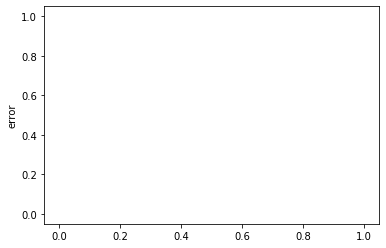

In [49]:

#test(network, [[1,0], [1,1], [0,0], [0,1]], 4)

#dataset = np.matrix(load_training_dataset([0,1, 3], 10))
#print('done')#network = retrain('img', 5000, 10, [0,1,3, 8, 9])
#test_dataset, filenames = load_testing_dataset('Testing data')
#test(network, test_dataset, 15, [0,1, 2, 3, 4, 5, 6, 7, 8, 9], filenames)

#network = train('xor', 4, 100, [], [16, 8], 2)
network = train('img', 1000, 10, [0,1, 2, 3, 4, 5, 6, 7 , 8, 9], [16], 1)
#predict('Testing data/', [0,1, 2, 3, 4, 5, 6, 7, 8, 9])

In [14]:
len(dataset)

10000